# Unsupervised Learning With Single Cell Data

## Set-up and Data Loading

In [1]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import scanpy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import loompy

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

RANDOM_SEED = 42

In [2]:
# Set ScanPy options
sp.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sp.logging.print_header()
sp.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.5.2 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


In [3]:
# Load the data set
cells = sp.read_h5ad("data/cells.h5ad")
cells

AnnData object with n_obs × n_vars = 50435 × 22956
    obs: 'CellFromTumor', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'nGene', 'nUMI', 'orig_ident', 'percent_mito', 'percent_ribo', 'seurat_clusters', 'tissue', 'type'
    var: 'Selected', 'detection_rate', 'gmean', 'residual_mean', 'residual_variance', 'variance'
    uns: 'seurat_clusters_colors', 'type_colors'
    obsm: 'X_umap', 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data'

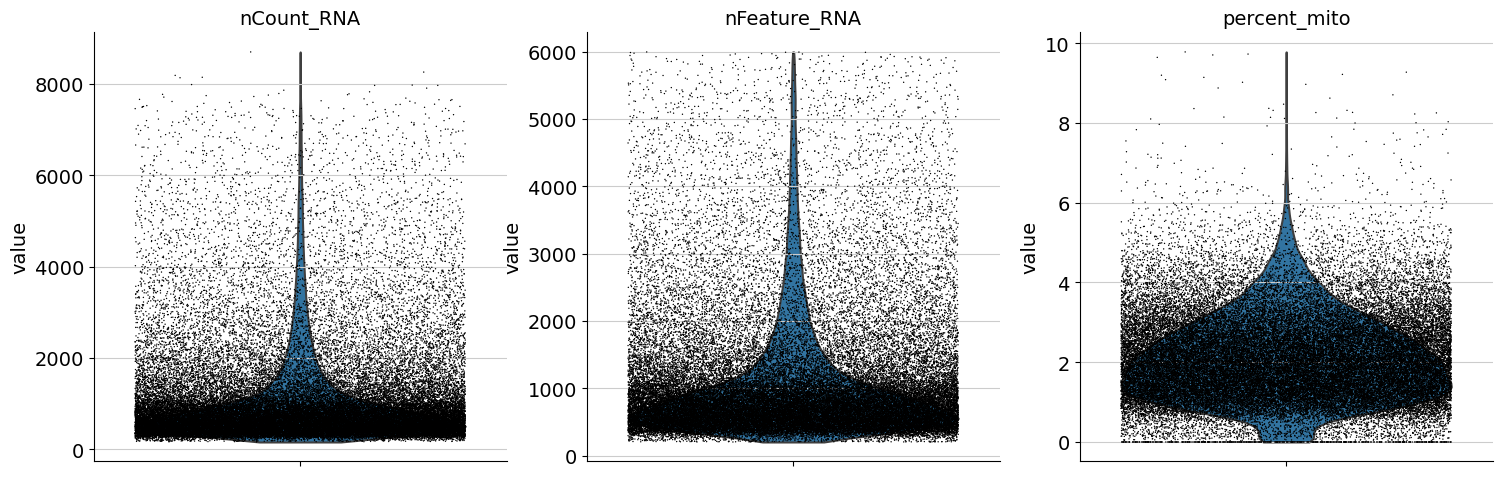

In [4]:
# Show some violin plots
sp.pl.violin(cells, ['nCount_RNA', 'nFeature_RNA', 'percent_mito'], jitter=0.4, multi_panel=True)

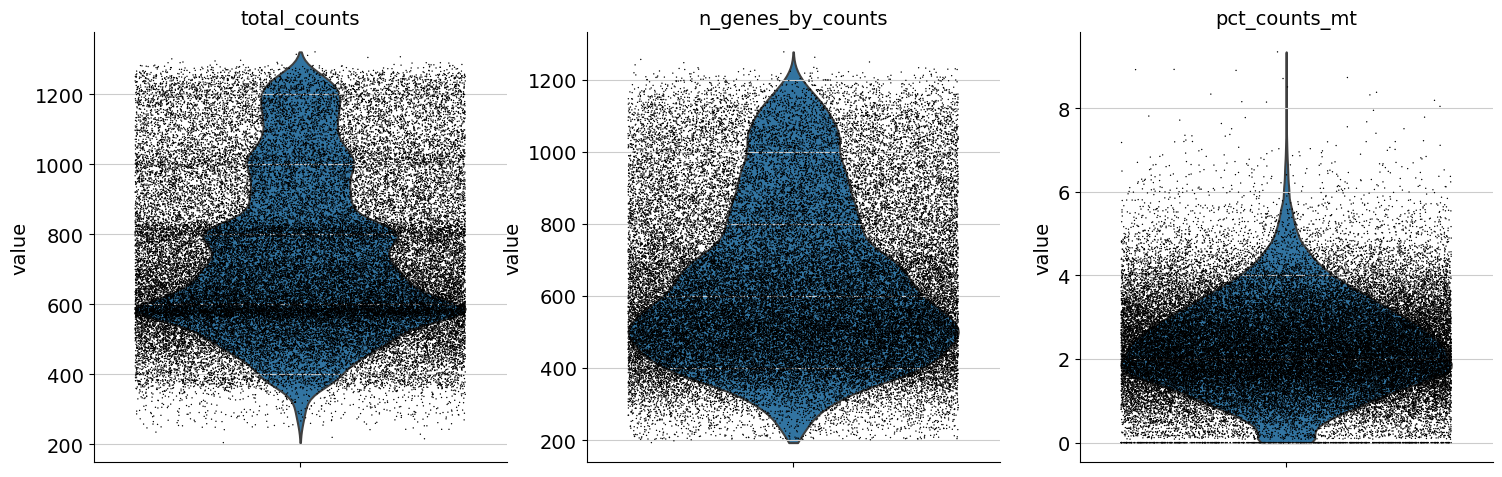

In [5]:
cells.var['mt'] = cells.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sp.pp.calculate_qc_metrics(cells, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sp.pl.violin(cells, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

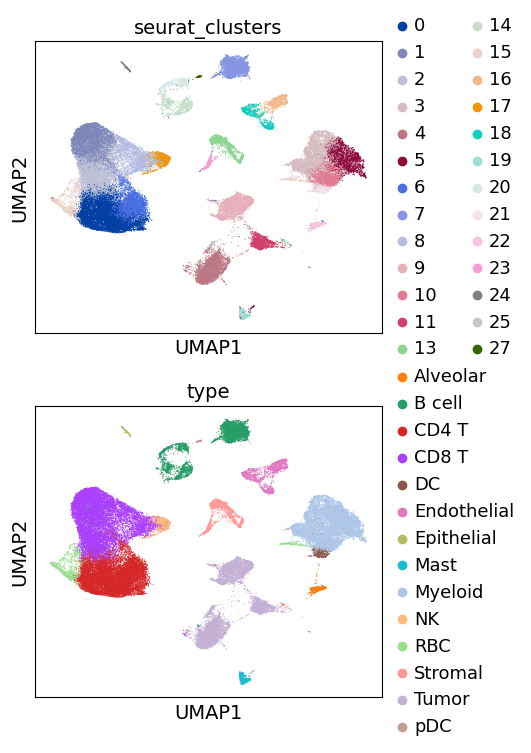

In [6]:
# Show the existing umap plots
sp.pl.umap(cells, color=["seurat_clusters", "type"], ncols=1)

## Splitting into Training and Test Sets

Our data needs to be split into training and test sets before we begin to work with the data.
This entails converting our AnnData object to data frames so they can easily be split into the training and test sets

In [7]:
# Get the raw counts for all cells
df = pd.DataFrame(cells.X, columns=cells.var_names, index=cells.obs_names)
cell_types = cells.obs['type']
print(cell_types[:5])
df.head()

CellID
AAACATACCTGAGT_1    CD4 T
AAAGAGACATCGTG_1    CD4 T
AACGCATGCTTAGG_1    CD4 T
AACTGTCTTGACAC_1    CD4 T
AAGAATCTCATGAC_1    CD4 T
Name: type, dtype: category
Categories (14, object): ['Alveolar', 'B cell', 'CD4 T', 'CD8 T', ..., 'RBC', 'Stromal', 'Tumor', 'pDC']


Gene,FO538757.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,RP11-54O7.2,RP11-54O7.3,SAMD11,NOC2L,...,AC145212.2,AC011043.1,AL592183.1,AC007325.4,AC007325.2,AL354822.1,AC004556.1,AC233755.2,AC233755.1,AC240274.1
CellID,,,,,,,,,,,,,,,,,,,,,
AAACATACCTGAGT_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGAGACATCGTG_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACGCATGCTTAGG_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACTGTCTTGACAC_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAATCTCATGAC_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Now we can split the data set into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(df, cell_types, random_state=RANDOM_SEED, stratify=cell_types, test_size=0.2)

In [9]:
print("Shape of training data: {}".format(X_train.shape))
print("Shape of training labels: {}".format(y_train.shape))
print("Shape of training data: {}".format(X_test.shape))
print("Shape of training labels: {}".format(y_test.shape))

Shape of training data: (40348, 22956)
Shape of training labels: (40348,)
Shape of training data: (10087, 22956)
Shape of training labels: (10087,)


In [10]:
# Show what the training dataframe looks like
X_train.head()

Gene,FO538757.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,RP11-54O7.2,RP11-54O7.3,SAMD11,NOC2L,...,AC145212.2,AC011043.1,AL592183.1,AC007325.4,AC007325.2,AL354822.1,AC004556.1,AC233755.2,AC233755.1,AC240274.1
CellID,,,,,,,,,,,,,,,,,,,,,
TCAGCTCCACTGTTAG_18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TGCTGCTTCGTGGTCG_24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TAAACCGAGCCAGTTT_23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GTAGTCACAGACAAGC_16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTAATGGGTCCAACTA_14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Write the training and test dataframes to files as they will be easier to work with downstream when using Scanpy
X_train_csv = "data/X_train.csv"
X_test_csv = "data/X_test.csv"
X_train.to_csv(X_train_csv)
X_test.to_csv(X_test_csv)

In [12]:
# Write out the training and test labels so they can be easily loaded in the future if we want to create other notebooks for testing different algorithms
y_train_csv = "data/y_train.csv"
y_test_csv = "data/y_test.csv"
y_train.to_csv(y_train_csv)
y_test.to_csv(y_test_csv)

## Normalization and PCA

Before we can start working with our data, we need to normalize the count data and then run PCA in order to reduce the dimensionality of our data set before inputting the results of PCA into our supervised clustering algorithm.

When normalizing the data, traditionally with single cell data a log normalization is done. This entails normalizing the feature expression measurements for each cell by the total expression, and multiplies with by a scale factor (ex, 10,000) and log transforms the result.

A good substitute for our data set will be to apply the log1p transformation which is log(1+count) for each cell in the dataframe

### Normalizing and PCA on Training Data

In [13]:
# Create an anndata object for the subsetted data frame
X_train_anndata = sp.read_csv(X_train_csv)
X_train_anndata

AnnData object with n_obs × n_vars = 40348 × 22956

normalizing counts per cell
    finished (0:00:01)


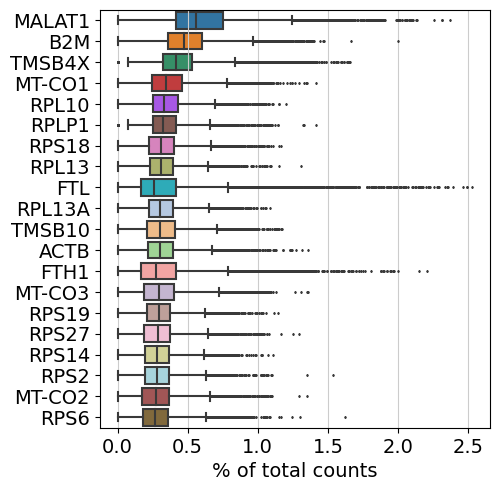

In [14]:
# Genes with highest fraction of counts in each single cell
sp.pl.highest_expr_genes(X_train_anndata, n_top=20)

In [15]:
# Count normalize
sp.pp.normalize_total(X_train_anndata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:01)


In [16]:
# Log transform the data
sp.pp.log1p(X_train_anndata)

In [17]:
# Detect the highly variable genes in the data set
sp.pp.highly_variable_genes(X_train_anndata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [18]:
# Freeze the state of the anndata object
X_train_anndata.raw = X_train_anndata

In [19]:
# Scale each gene to unit variance
sp.pp.scale(X_train_anndata, max_value=10)

In [20]:
# Do PCA
sp.tl.pca(X_train_anndata, n_comps=100, random_state=RANDOM_SEED)

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:19)


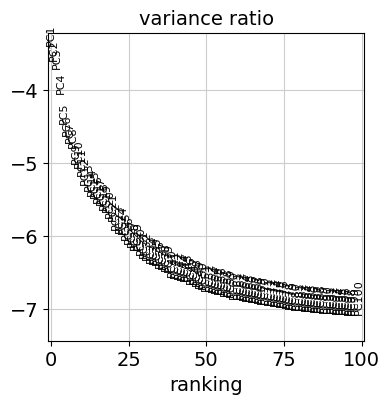

In [21]:
# Look at the results of PCA to determine which is the "best" number of PC's to use
sp.pl.pca_variance_ratio(X_train_anndata, n_pcs=100, log=True)

In [23]:
# Now we pull out the number of PC's and use that when fitting our models
X_train_pca = pd.DataFrame(X_train_anndata.obsm['X_pca'], columns=["PC_{}".format(i) for i in range(1,101)], index=X_train_anndata.obs_names)
X_train_pca

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100
TCAGCTCCACTGTTAG_18,-4.992898,1.977512,2.635585,0.294222,-0.352567,0.480021,-0.607563,0.537430,0.354954,0.988223,...,-0.462595,0.087632,-0.052814,0.556481,0.054679,0.224687,-0.169372,0.542473,-0.846556,0.508644
TGCTGCTTCGTGGTCG_24,10.464969,-4.179771,10.248443,13.373019,-0.398255,-1.284958,2.211708,0.475676,-0.210210,2.024232,...,-1.277322,1.558493,-0.576285,0.077916,4.163789,-2.981526,2.011886,-2.500266,-2.785338,-0.459860
TAAACCGAGCCAGTTT_23,11.897520,10.368339,-9.752758,-0.730833,-6.437627,-3.039113,1.155997,-0.674257,1.225248,0.872168,...,-1.720228,2.017140,-0.437280,-0.466851,1.741052,2.206027,0.025159,0.891565,0.706938,-0.884677
GTAGTCACAGACAAGC_16,0.143765,-8.355688,-4.339621,-0.964090,1.019565,-0.285464,-0.621728,-0.871520,0.075748,-0.569459,...,-0.432451,0.092293,-0.112975,-0.005309,1.322929,-0.699168,0.830767,0.142431,0.077536,-0.580421
CTAATGGGTCCAACTA_14,-4.288423,1.525269,2.442538,-1.382998,0.668751,2.043469,-2.643858,1.329928,-2.210888,-2.007604,...,0.774195,0.386610,0.501843,-2.406686,-0.897364,0.785435,1.719489,1.565058,1.476145,2.158217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTACGTCAGTTACGGG_23,-3.217075,3.317140,0.734149,-0.171841,-2.589298,1.034886,0.091525,1.328651,0.166677,0.536796,...,-0.280567,0.183430,-0.391207,1.418837,-0.849048,-0.228011,0.836546,0.289488,-0.149310,0.706845
AGGTCATAGCTCCCAG_19,3.871933,5.376078,-0.844322,-1.208035,12.304910,-12.572667,1.558587,1.102530,2.344621,0.131251,...,1.391068,0.864805,0.329855,0.962625,-0.532537,-0.251960,-0.223894,-1.007607,-1.570256,0.937821
GGATTACAGCACACAG_23,-3.675462,4.540859,1.770640,-1.032971,-2.875718,0.858732,-1.186413,1.848589,-1.039351,-1.014755,...,-0.710639,-0.939619,0.350428,0.324328,0.808764,0.253990,0.043454,-0.635487,-0.043112,0.071773
CGTGTCTGTTTGCATG_17,-4.479670,1.568713,1.886735,-0.100764,-1.068602,0.053147,-0.073407,0.830149,0.781056,0.594118,...,0.457879,-0.962235,-0.455454,0.454581,0.566082,-0.579898,-0.087339,-0.194729,-0.144553,-0.375817


### Normalization and PCA on Test Data

In [24]:
# We are going to be following the same steps as above so everything will be in a single block instead of being spread across multiple
X_test_anndata = sp.read_csv(X_test_csv)
sp.pp.normalize_total(X_test_anndata, target_sum=1e4)
sp.pp.log1p(X_test_anndata)
sp.pp.highly_variable_genes(X_test_anndata, min_mean=0.0125, max_mean=3, min_disp=0.5)
X_test_anndata.raw = X_test_anndata
sp.pp.scale(X_test_anndata, max_value=10)
sp.tl.pca(X_test_anndata, n_comps=100, random_state=RANDOM_SEED)
X_test_pca = pd.DataFrame(X_test_anndata.obsm['X_pca'], columns=["PC_{}".format(i) for i in range(1,101)], index=X_test_anndata.obs_names)
X_test_pca

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:07)


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100
GTCTCGTCAGTCCTTC_14,-2.121864,2.744564,1.005692,0.330697,1.934033,2.341517,-3.875904,0.775422,-1.268073,0.357641,...,-0.773103,0.568551,0.357325,0.225283,0.924969,0.698910,-1.314906,-0.325849,0.316512,-0.450041
TTGAGGTGATCACG_11,-5.620925,2.676958,3.018107,-0.443643,-0.667588,1.502346,-0.397419,-0.601445,-0.725637,-0.053183,...,-0.107937,1.141594,-0.196161,-0.112389,-1.318708,0.117391,0.795960,0.159382,0.715823,-0.023592
TGCCAGCTGGATCT_1,4.761631,5.481067,-2.692788,-1.248277,1.187206,-3.817649,4.808956,-1.325152,4.023226,1.889403,...,1.445136,0.198292,1.060791,-0.378182,-0.231459,-1.267475,-0.011771,1.599348,0.963045,-0.691072
TGAGAGGCATGTCGAT_17,-0.912354,-11.043016,-8.724866,-0.180805,-0.210758,-0.494613,0.710579,-2.521290,0.439421,-0.063892,...,0.730286,0.415982,-0.696639,-0.238476,0.392612,0.014038,-0.282079,0.731216,-1.074669,0.652429
TCTCATAAGTTTAGGA_24,-3.657376,0.729686,1.696968,0.193875,-0.404606,0.375957,-0.099063,-0.274293,0.923657,0.010611,...,-0.333540,0.718053,0.687776,0.688554,1.048194,-0.904632,0.375872,0.501695,0.667737,-0.310641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTCCTAGCATTAACCG_19,-1.072866,1.475953,0.460632,-1.585916,-0.057282,0.032152,3.343806,9.551888,-0.963302,-2.106752,...,-0.726004,1.261021,1.006244,0.331683,0.824301,-0.487810,-0.642503,-0.641821,-0.704575,0.796393
TCTATTGTCATGCAAC_20,-4.458004,2.727519,3.089555,-0.722311,0.654921,-0.025390,0.462278,-2.945137,-0.254651,0.000045,...,-0.805445,0.962132,0.341569,1.637868,-0.075426,-0.209664,0.790990,-0.635044,0.739844,1.262402
GCTTCCATCAAGGTAA_21,2.713277,-10.394182,-9.289550,-1.616829,-0.955664,1.264926,2.110059,-0.943279,0.539982,-0.307624,...,-2.855619,-0.349462,-1.516291,1.592565,0.153090,1.322047,-0.002408,0.046413,0.620575,-0.886167
CTCGTCAGTCCCTACT_19,-5.039543,2.453936,3.206162,0.123347,-0.746609,0.715151,-0.338621,0.074381,0.197562,-0.671676,...,-0.074462,0.169910,-0.016632,-1.339488,0.108403,1.483644,-2.027208,0.501576,0.507480,0.449675


In [25]:
# Write the PCA data out to CSV files so they can be easily loaded in different notebooks
X_train_pca_csv = "data/X_train_pca.csv"
X_test_pca_csv = "data/X_test_pca.csv"
X_train_pca.to_csv(X_train_pca_csv)
X_test_pca.to_csv(X_test_pca_csv)

## Testing Machine Learning Models to Predict Classification

### kNN Classifier

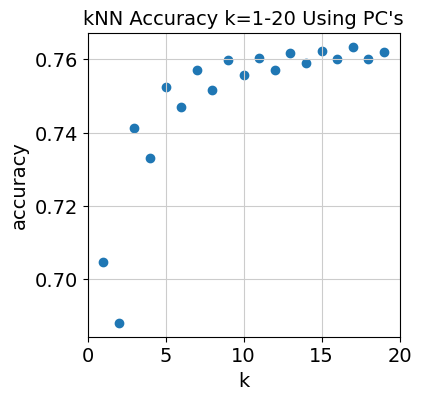

In [26]:
# Run a variety of kNN's to see which performs the best on our data set
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_pca, y_train)
    scores.append(knn.score(X_test_pca, y_test))

plt.figure()
plt.title("kNN Accuracy k=1-20 Using PC's")
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);

In [28]:
# Just out of curiosity, let's try and train the model with the full data set instead of the PC's and see how the accuracy performs
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7144839892931496

In [29]:
# Let's take a crack at a confusion matrix. I'll set n_neighbors=15 as that seems to give a good accuracy with the plots above
knn = KNeighborsClassifier(n_neighbors = 15).fit(X_train_pca, y_train)
knn_predicted = knn.predict(X_test_pca)
confusion_mtx = confusion_matrix(y_test, knn_predicted, labels = sorted(y_test.unique()))
df_cm = pd.DataFrame(confusion_mtx, index = sorted(y_test.unique()), columns = sorted(y_test.unique()))

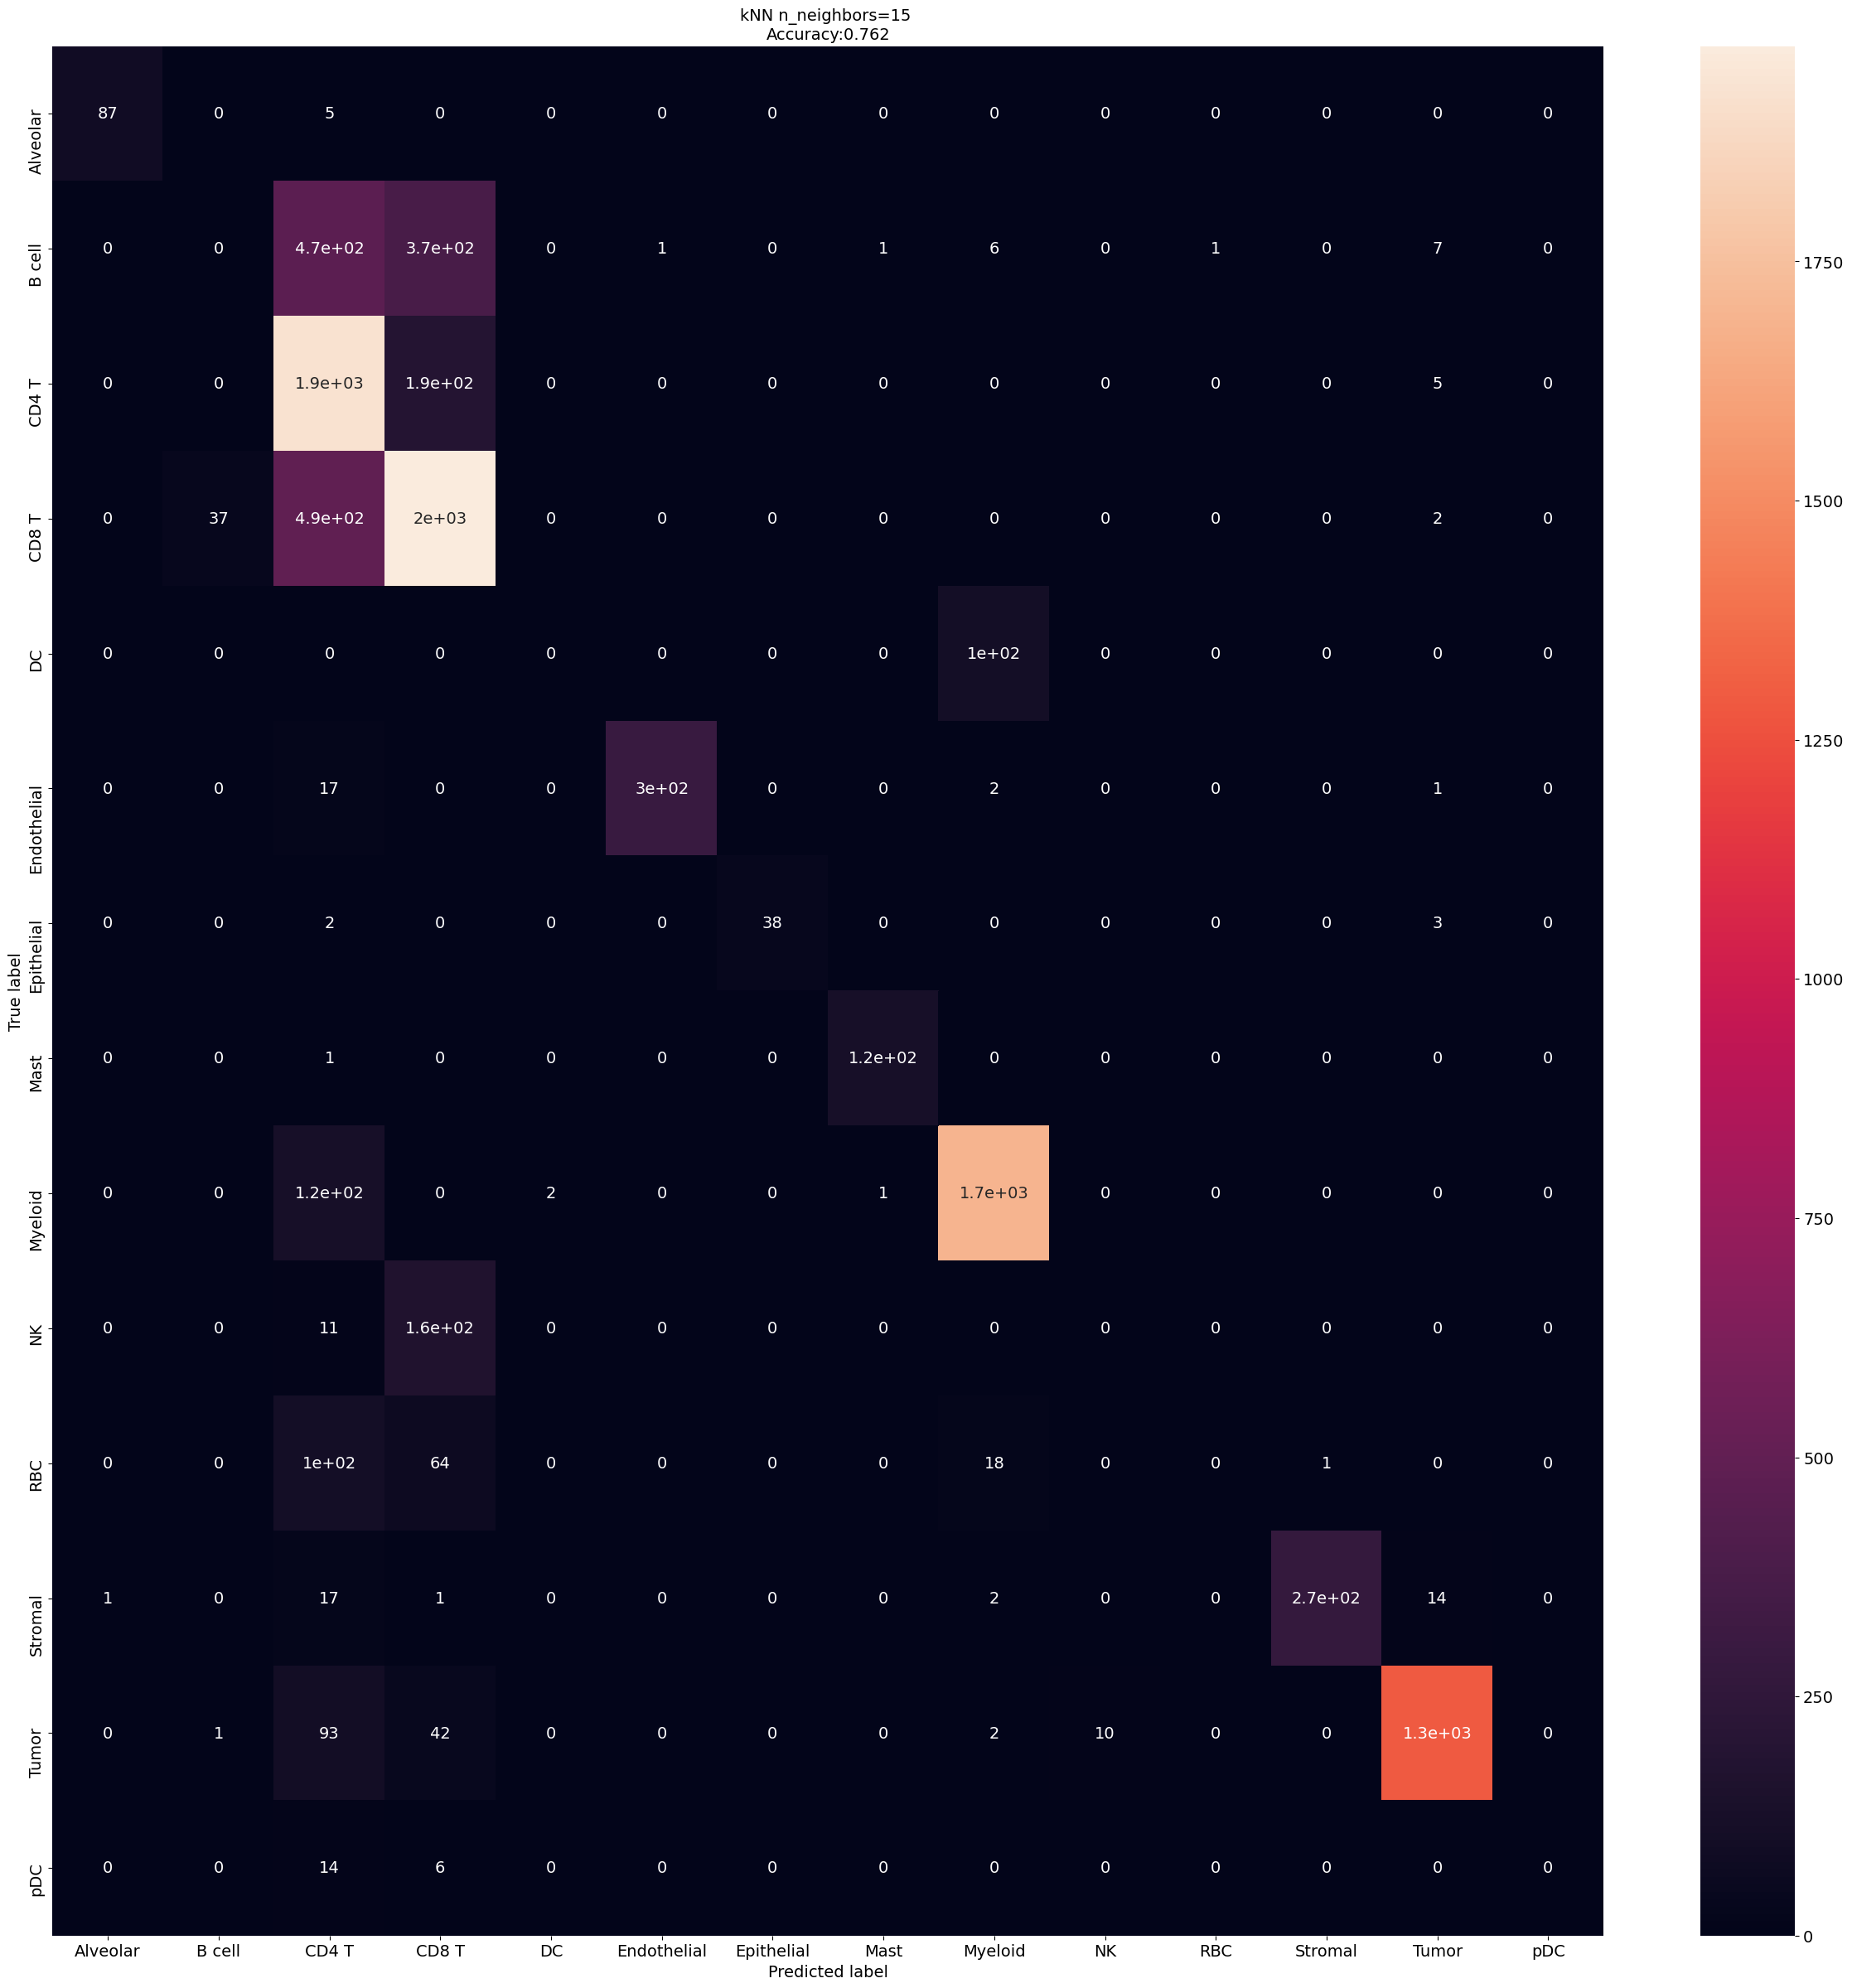

In [30]:
plt.figure(figsize = (30,30))
sns.heatmap(df_cm, annot=True)
plt.title('kNN n_neighbors=15 \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, knn_predicted)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("knn_confusion.jpg")